# Exercici 3: ¿Quién hace ruido en Barcelona por la noche?

In [1]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from yellowbrick.regressor import prediction_error
from sklearn.neighbors import KNeighborsRegressor
from apafib import load_BCN_ruido
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import seaborn as sn
import pandas as pd
import numpy as np

In [2]:
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [3]:
RANDOM_STATE = 0
CV = 3
NITER = 40

## Utils

In [4]:
def plot_data_frame_histogram (df):
    fig, axes = plt.subplots(len(df.keys()) // 2, 2, figsize=(10,20))

    # We will not plot country because it has too many categories.
    for i, c in enumerate(df.columns):
        ax = axes.reshape(-1)[i]
        c_ = c
        if len(c) > 50:
            count = 50
            while count < len(c) and c[count] != " ":
                count += 1
            if count != len(c):
                c_ = (c[:count] + "\n" + c[count:])
        if df[c].dtype.kind == 'O':
            a = sn.countplot(x=c,data=df,ax=ax)
        else:
            b = sn.histplot(x=c,data=df,ax=ax)
        ax.set_title(c_)
    plt.tight_layout()

In [5]:
def scale_dataset_and_split_into_train_test(df, scaler, train_size=80):
    X = df[df.columns.difference(['Contaminació acústica: Decibels / 4h'])]
    y = df[['Contaminació acústica: Decibels / 4h']]
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size, random_state=RANDOM_STATE)
    return scaler, (X_train, X_test, y_train, y_test)

In [6]:
def linear_regression_fit(model, x_train, y_train, x_test, y_test, show_predicted_error=True, get_coef=False):
    model.fit(x_train, y_train.squeeze())
    params = model.get_params()
    score = model.score(x_test, y_test.squeeze())
    coef = model.coef_ if get_coef else None
    if show_predicted_error:
        plt.figure(figsize=(5,5))
        prediction_error(model, x_test, y_test.squeeze(), is_fitted=True)
        plt.show()
    cross_value = cross_val_score(model, x_test, y_test.squeeze())
    return score, coef, params, cross_value

## Apartado a)

In [13]:
df = load_BCN_ruido()
df.head()

,Visitants a Barcelona segons municipi d’origen / Badalona,Visitants a Barcelona segons municipi d’origen / L'Hospitalet de Llobregat,Visitants a Barcelona segons municipi d’origen / Sabadell,Visitants a Barcelona segons municipi d’origen / Santa Coloma de Gramenet,Visitants a Barcelona segons municipi d’origen / Terrassa,Visitants a Barcelona segons país d’origen / Estats Units,Visitants a Barcelona segons país d’origen / França,Visitants a Barcelona segons país d’origen / Itàlia,Visitants a Barcelona segons país d’origen / Països Baixos,Visitants a Barcelona segons país d’origen / Regne Unit,Visitants a Barcelona segons província d’origen / Girona,Visitants a Barcelona segons província d’origen / Illes Balears,Visitants a Barcelona segons província d’origen / Lleida,Visitants a Barcelona segons província d’origen / Madrid,Visitants a Barcelona segons província d’origen / Tarragona,Contaminació acústica: Decibels / 4h
0,40999.0,77619.0,9223.0,37267.0,8862.0,409.0,10471.0,433.0,619.0,668.0,7549.0,2071.0,2771.0,6461.0,7489.0,48.13
1,56515.0,91817.0,11894.0,42309.0,10445.0,551.0,10897.0,591.0,648.0,858.0,8805.0,2493.0,3529.0,7545.0,7933.0,45.74
2,50135.0,85142.0,10405.0,39708.0,8891.0,472.0,8149.0,682.0,540.0,756.0,8613.0,2668.0,3225.0,7114.0,7640.0,46.91
3,73971.0,108752.0,18806.0,47866.0,17357.0,461.0,5437.0,554.0,517.0,787.0,12451.0,2823.0,4738.0,7021.0,13027.0,45.99
4,72851.0,110814.0,19057.0,48995.0,17257.0,428.0,4245.0,526.0,527.0,799.0,12371.0,2439.0,4565.0,6410.0,13016.0,46.99


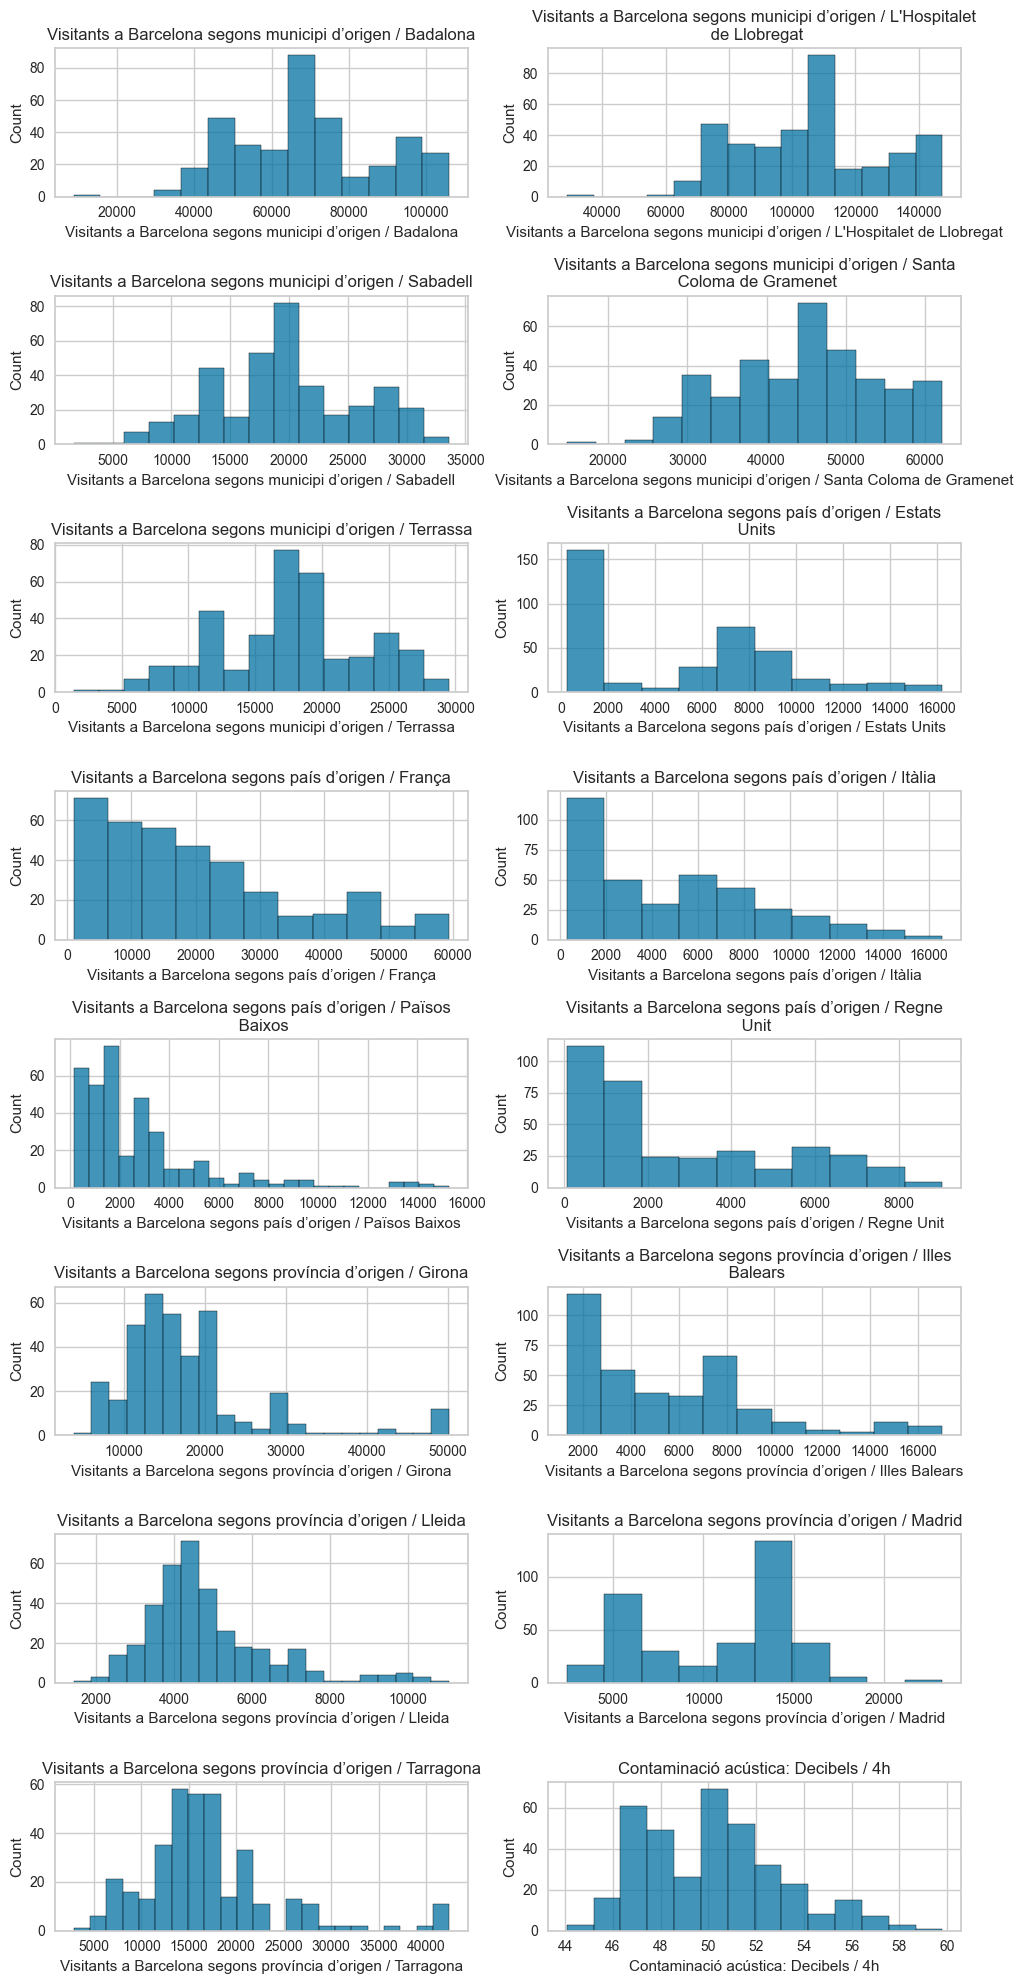

In [14]:
plot_data_frame_histogram(df)

<AxesSubplot:>

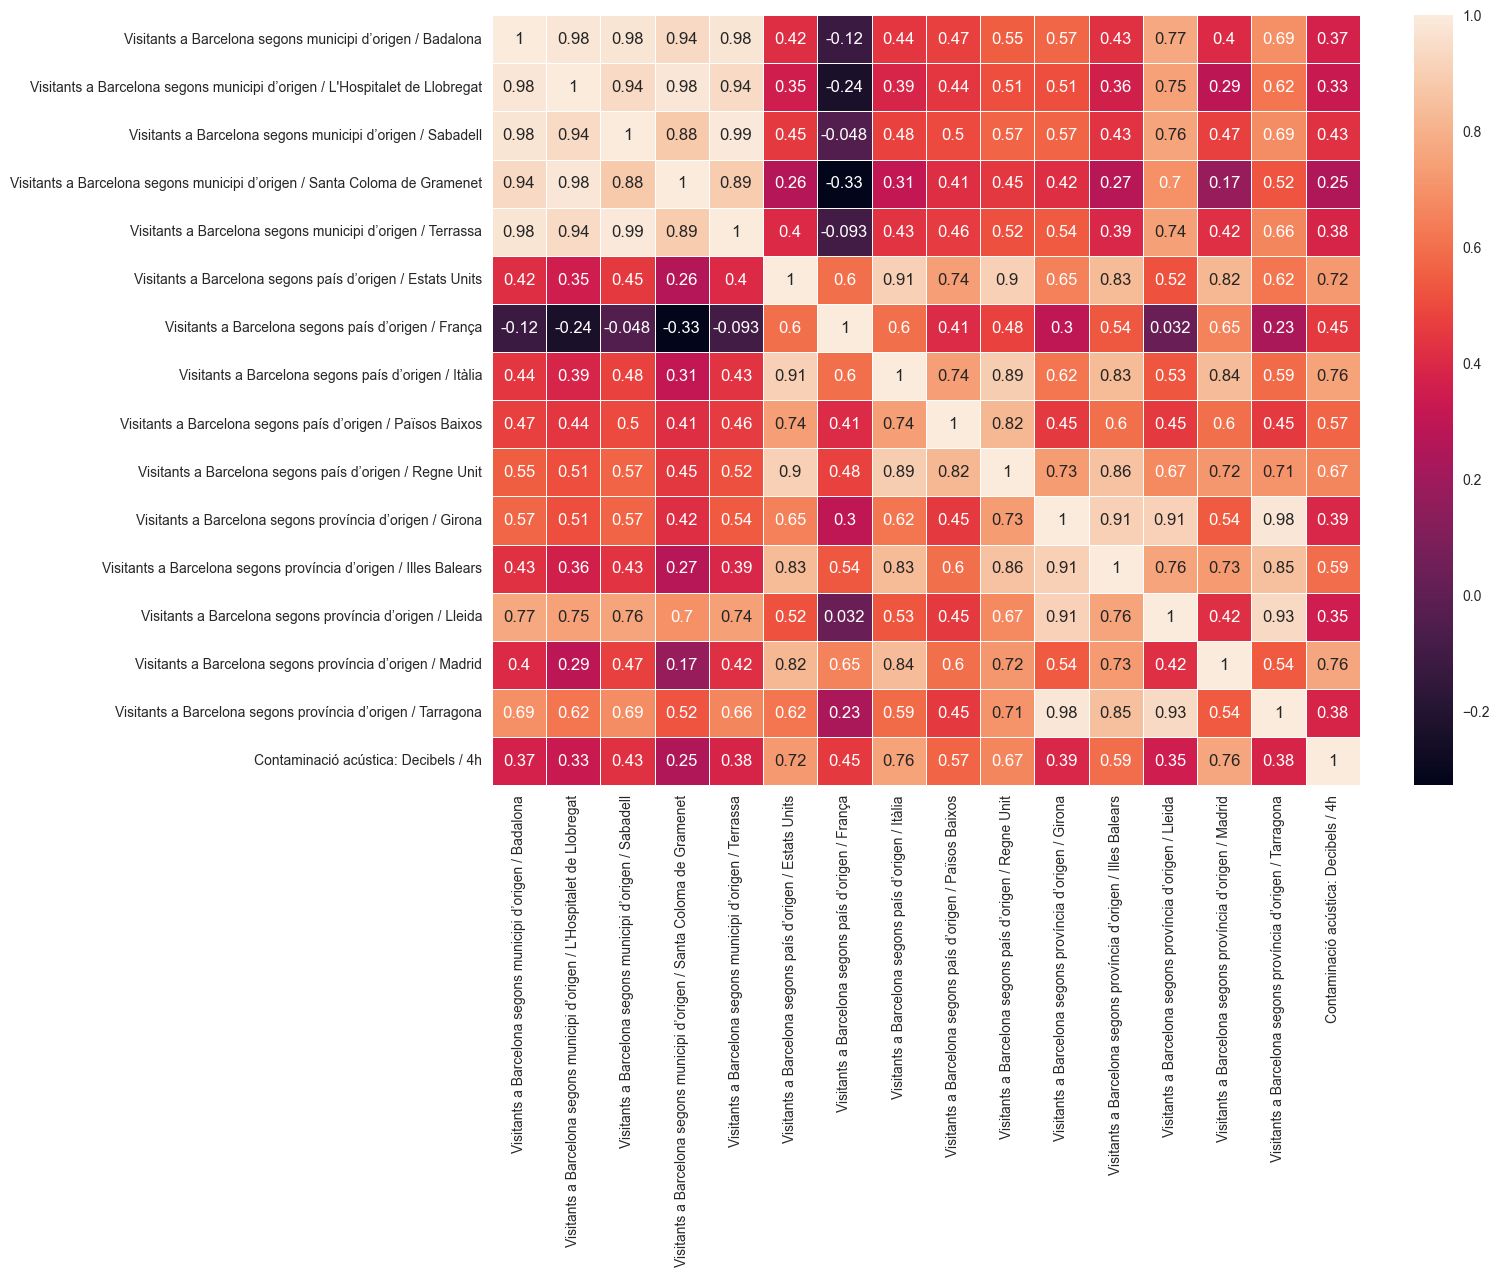

In [15]:
correlation_matrix = df.corr()
fig, ax = plt.subplots(figsize=(14,10))
sn.heatmap(correlation_matrix, annot=True, linewidths=.5, ax=ax)

In [16]:
standard_scaler, (X_train, X_test, y_train, y_test) = scale_dataset_and_split_into_train_test(df, StandardScaler())

Como curiosidades del conjunto de datos, encontramos que los visitantes que generan mas ruido en la ciudad de Barcelona son aquellos que provienen de Madrid y Italia. Además, cabe destacar que aquellas ciudades que estan más alejadas de la ciudad de Barcelona, tienen una mayor variabilidad de visitantes, respecto aquellas que són más proximas a la ciudad de Barcelona.

## Apartado b)

In [24]:
param = {'n_neighbors': [1, 3, 5, 7, 11, 15, 51], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn =  KNeighborsRegressor()
knn_gs =  GridSearchCV(knn,param,cv=CV, n_jobs=-1)
knn_gs.fit(X_train, y_train.values.squeeze());

In [25]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
124,"{'leaf_size': 10, 'metric': 'cosine', 'n_neighbors': 51, 'weights': 'distance'}",0.551027,1
208,"{'leaf_size': 30, 'metric': 'cosine', 'n_neighbors': 51, 'weights': 'distance'}",0.551027,1
82,"{'leaf_size': 5, 'metric': 'cosine', 'n_neighbors': 51, 'weights': 'distance'}",0.551027,1
166,"{'leaf_size': 20, 'metric': 'cosine', 'n_neighbors': 51, 'weights': 'distance'}",0.551027,1
40,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 51, 'weights': 'distance'}",0.551027,1


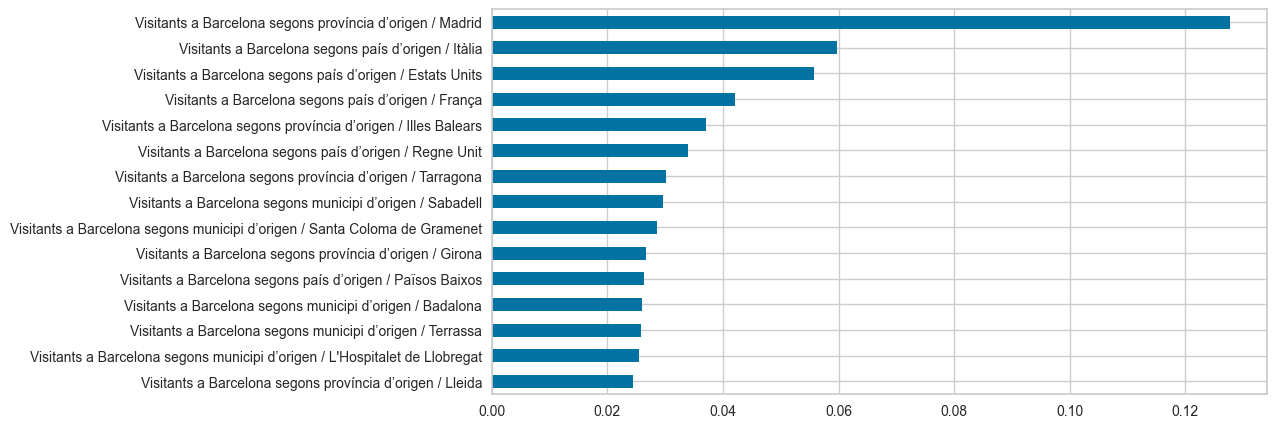

In [26]:
c = np.random.choice(X_test.shape[0], size=2000)
pi = permutation_importance(knn_gs,X_test[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=df.columns[:-1])
var_imp.sort_values(by='importance').plot.barh(figsize=(10,5), legend=False);

In [27]:
param = {'C': 10**np.linspace(-3,3,101), 'gamma': ['scale','auto']}

rbsvc = SVR(kernel='rbf', max_iter=25000)
rbsvc_gs = BayesSearchCV(rbsvc, param, n_iter=NITER, cv=CV, n_jobs=-1, refit=True, random_state=RANDOM_STATE)
rbsvc_gs.fit(X_train, y_train.values.squeeze());

In [28]:
show_html(pd.DataFrame(rbsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
12,"{'C': 6.918309709189363, 'gamma': 'scale'}",0.515669,1
37,"{'C': 13.803842646028839, 'gamma': 'scale'}",0.509437,2
7,"{'C': 1.1481536214968828, 'gamma': 'scale'}",0.491897,3
35,"{'C': 3.981071705534969, 'gamma': 'scale'}",0.491623,4
0,"{'C': 1.513561248436207, 'gamma': 'scale'}",0.483638,5


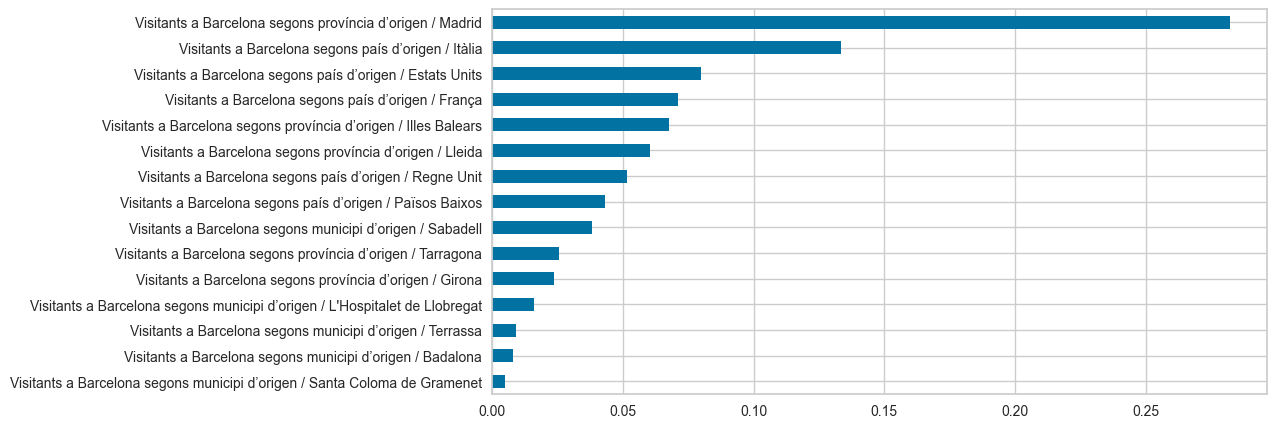

In [29]:
c = np.random.choice(X_test.shape[0], size=2000)
pi = permutation_importance(rbsvc_gs,X_test[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=df.columns[:-1])
var_imp.sort_values(by='importance').plot.barh(figsize=(10,5), legend=False);

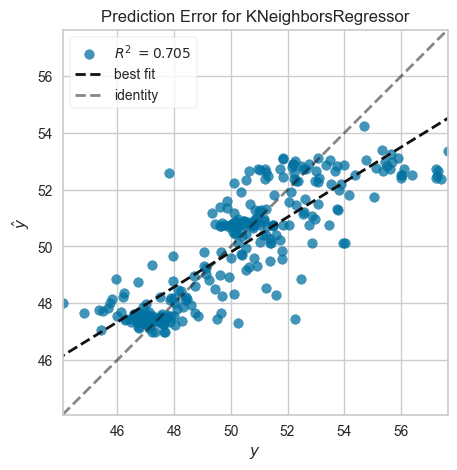

In [30]:
kn_score, kn_coef, kn_params, kn_cross = linear_regression_fit(KNeighborsRegressor(leaf_size=10, metric='cosine', n_neighbors=50, weights='distance'), X_train, y_train, X_test, y_test)

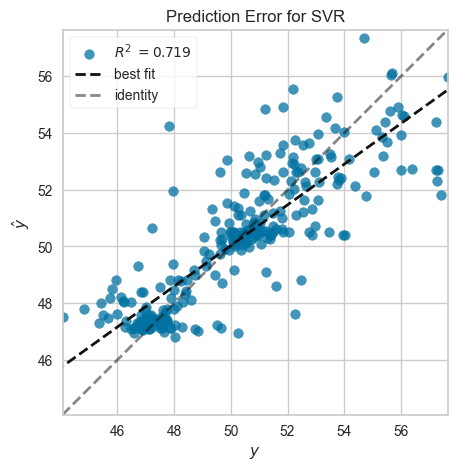

In [31]:
svr_score, svr_coef, svr_params, svr_cross = linear_regression_fit(SVR(kernel='rbf', max_iter=25000, C=6.918309709189363, gamma='scale'), X_train, y_train, X_test, y_test)

## Apartado c)

In [32]:
param = {'n_estimators': [5, 10, 25, 40, 50, 75, 100, 200], 
         'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
         'max_depth': [None, 1, 2, 3, 5, 8, 9,10,15],
         'min_samples_leaf': [1,2,3,5,10]}

rf =  RandomForestRegressor(random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=NITER, cv=CV, n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train, y_train.values.squeeze());

In [33]:
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
14,"{'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 5}",0.513594,1
24,"{'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 200}",0.513002,2
35,"{'criterion': 'friedman_mse', 'max_depth': 9, 'min_samples_leaf': 10, 'n_estimators': 200}",0.512458,3
29,"{'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_leaf': 10, 'n_estimators': 200}",0.512458,3
30,"{'criterion': 'friedman_mse', 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 200}",0.512458,3


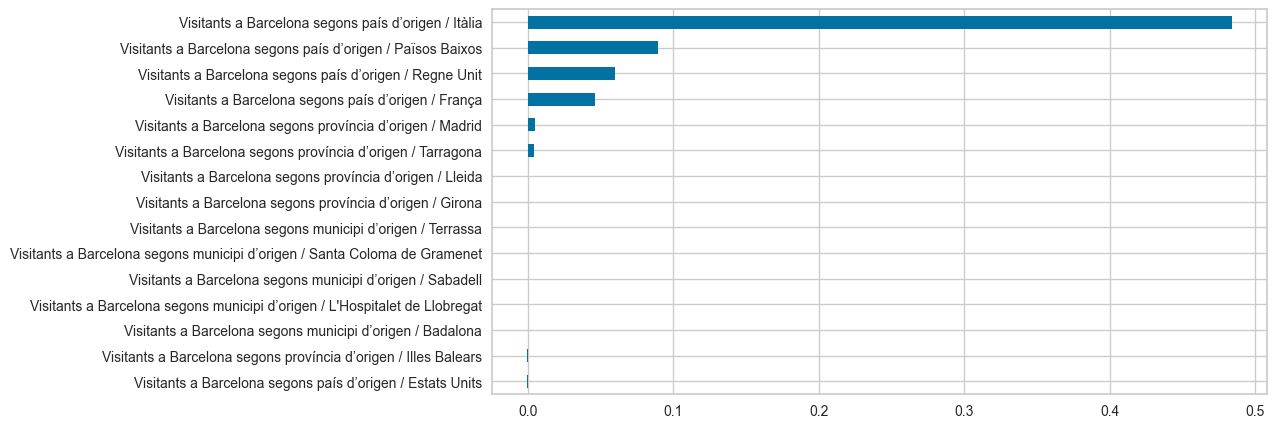

In [34]:
c = np.random.choice(X_test.shape[0], size=2000)
pi = permutation_importance(rf_bs,X_test[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=df.columns[:-1])
var_imp.sort_values(by='importance').plot.barh(figsize=(10,5), legend=False);

In [35]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['squared_error', 'absolute_error', 'huber', 'quantile'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingRegressor(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=NITER, cv=CV, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train, y_train.values.squeeze());

/Users/ignasi/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ignasi/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ignasi/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ignasi/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ignasi/.local/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has be

In [36]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
28,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 25}",0.356182,1
2,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.339630,2
15,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'huber', 'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 40}",0.265742,3
19,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'huber', 'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 25}",0.256040,4
10,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 40}",0.060312,5


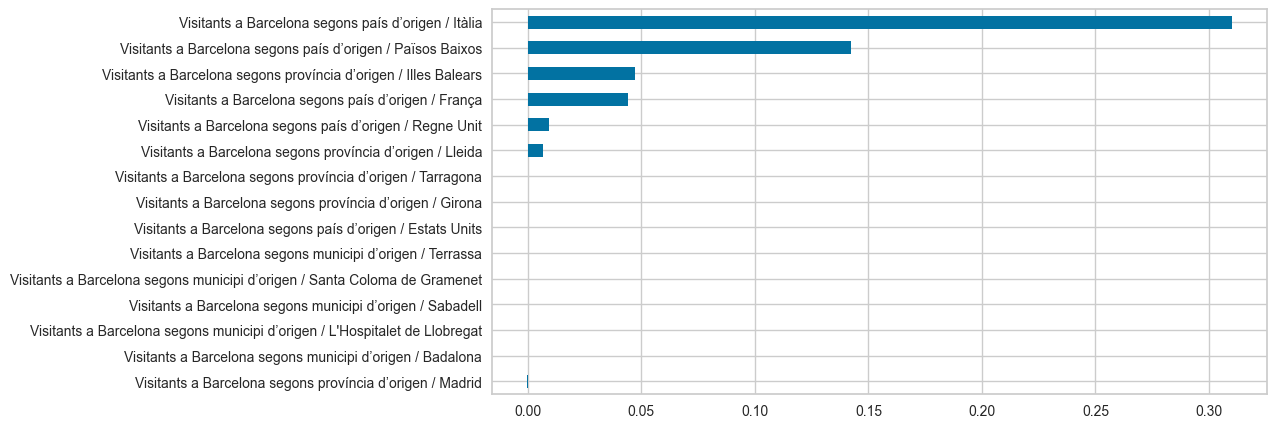

In [37]:
c = np.random.choice(X_test.shape[0], size=2000)
pi = permutation_importance(gb_bs,X_test[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=df.columns[:-1])
var_imp.sort_values(by='importance').plot.barh(figsize=(10,5), legend=False);

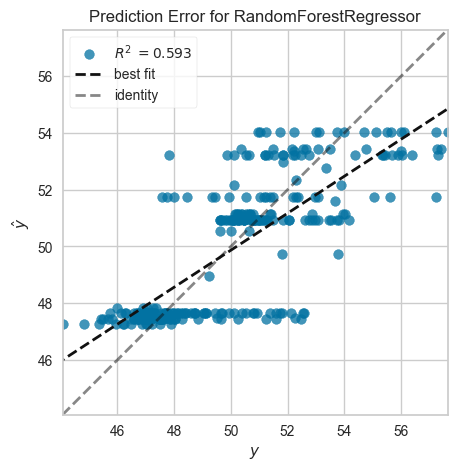

In [38]:
rf_score, rf_coef, rf_params, rf_cross = linear_regression_fit(RandomForestRegressor(criterion='squared_error', max_depth=10, min_samples_leaf=10, n_estimators=5), X_train, y_train, X_test, y_test)

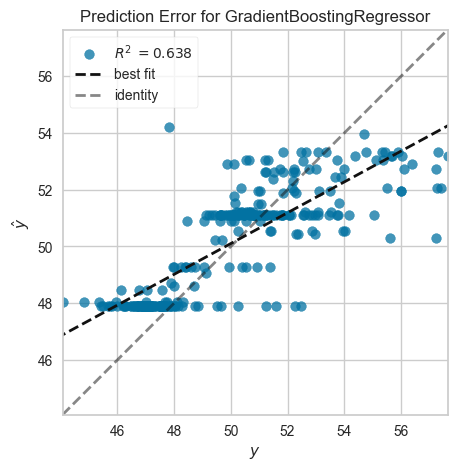

In [39]:
gb_score, gb_coef, gb_params, gb_cross = linear_regression_fit(GradientBoostingRegressor(random_state=0,n_iter_no_change=5,criterion='squared_error',learning_rate=0.1,loss='huber',max_depth=1,min_samples_leaf=2,n_estimators=25), X_train, y_train, X_test, y_test)

## Apartado d)

In [40]:
estimators = [('svr', SVR(kernel='rbf', max_iter=25000, C=6.918309709189363, gamma='scale')), ('rfr', RandomForestRegressor(criterion='squared_error', max_depth=10, min_samples_leaf=10, n_estimators=5))]

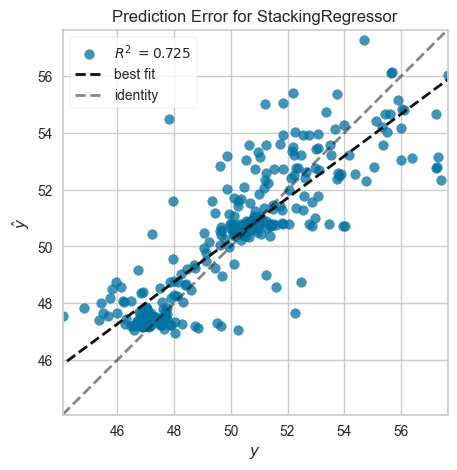

In [41]:
reg_score, reg_coef, reg_params, reg_cross = linear_regression_fit(StackingRegressor(estimators=estimators), X_train, y_train, X_test, y_test)

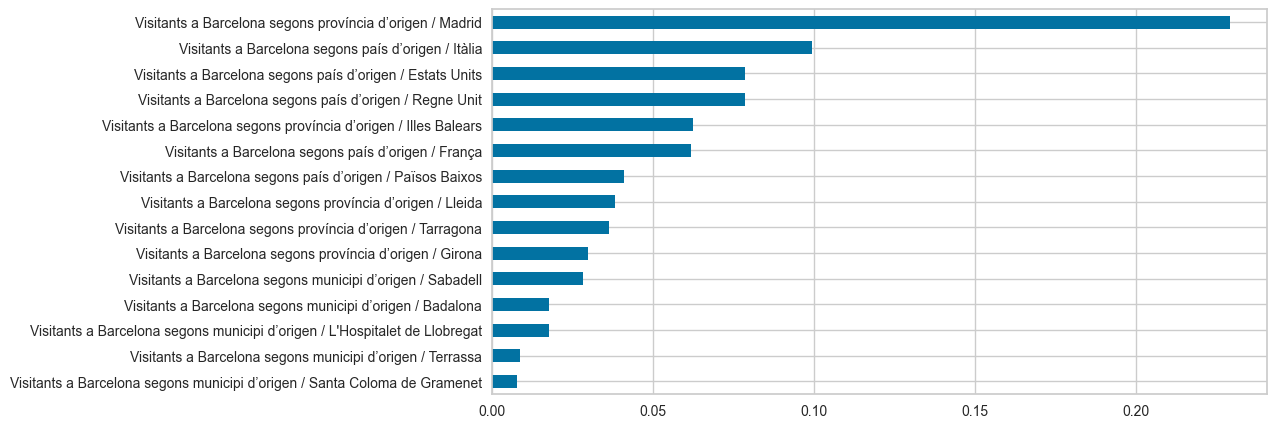

In [42]:
reg = StackingRegressor(estimators=estimators)
reg.fit(X_train, y_train.values.squeeze())
c = np.random.choice(X_test.shape[0], size=2000)
pi = permutation_importance(reg,X_test[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=df.columns[:-1])
var_imp.sort_values(by='importance').plot.barh(figsize=(10,5), legend=False);

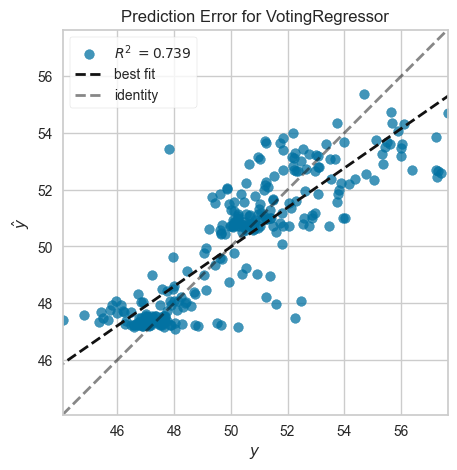

In [43]:
vot_score, vot_coef, vot_params, vot_cross = linear_regression_fit(VotingRegressor(estimators=estimators), X_train, y_train, X_test, y_test)

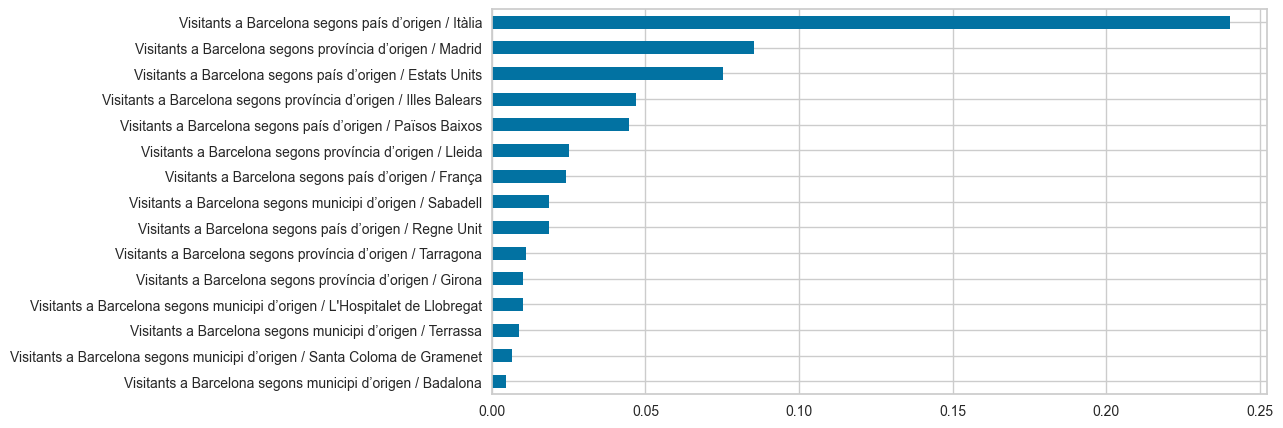

In [44]:
vot = VotingRegressor(estimators=estimators)
vot.fit(X_train, y_train.values.squeeze())
c = np.random.choice(X_test.shape[0], size=2000)
pi = permutation_importance(vot,X_test[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=df.columns[:-1])
var_imp.sort_values(by='importance').plot.barh(figsize=(10,5), legend=False);

Se puede ver como el modelo VotingRegressor ha obtenido mejores resultados que los anteriores. Si nos en que ciudades són aquellas que llevan visitantes más ruidosos, encontramos Madrid y Italia, hecho que se repite en todos los modelos. 